# Part A

In [1]:
from pandas import Series, DataFrame
import pandas as pd
import nltk
import operator
import re,string
from patsy import dmatrices
%pylab inline

/Users/pranjor/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


## A1. What are the top 5 parts of speech in this corpus of job descriptions? How frequently do they appear?

### (1) import file

In [2]:
train = pd.read_csv('/Users/pranjor/Documents/UT/MSBA/Text Analytics/project 1/Train_rev1.csv')

### (2) tokenize the corpus

In [4]:
description  = train['FullDescription'][:1000]

corpus = description.str.cat(sep=' ')

corpus = corpus.decode('utf-8')

corpus_words = nltk.word_tokenize(corpus.lower())
corpus_words = [word for word in corpus_words if word.isalpha()==True]

### (3) Calculate the frequencies of PoS

In [5]:
pos = nltk.pos_tag(corpus_words)

pos[:10]

[(u'engineering', 'NN'),
 (u'systems', 'NNS'),
 (u'analyst', 'NN'),
 (u'dorking', 'VBG'),
 (u'surrey', 'JJ'),
 (u'salary', 'JJ'),
 (u'our', 'PRP$'),
 (u'client', 'NN'),
 (u'is', 'VBZ'),
 (u'located', 'VBN')]

In [6]:
pos_freq = sorted(pos, key=lambda x: x[1],reverse=True)

df_pos = pd.DataFrame(pos_freq)


df_pos.columns = ['word','pos']

df_pos.groupby('pos').count().sort('word',ascending=False)[:5]

/Users/pranjor/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,word
pos,
NN,51790
JJ,23246
IN,23123
DT,17170
NNS,15271


## A2. Does this corpus support Zipf’s law? Plot the most common 100 words in the corpus against the theoretical prediction of the law.

### (1) Calculate the frequencies of words

In [7]:
fdist = nltk.FreqDist(corpus_words)

In [8]:
c_sorted = sorted(fdist.items(), key=operator.itemgetter(1),reverse=True)

df = pd.DataFrame.from_records(c_sorted)
df.columns = ['word','freq']
df[:10]

,word,freq
0,and,8435
1,the,7121
2,to,6677
3,a,5812
4,of,4547
5,in,4229
6,for,3450
7,care,3033
8,with,2652
9,you,2469


### (2) Get rid of the punctuation marks and then rank 

In [9]:
mask = ~df['word'].isin(set(string.punctuation)) 

df = df[mask]

df['rank'] = df['freq'].rank(method='min',ascending=False)

In [10]:
df[:5][['word','freq','rank']]

,word,freq,rank
0,and,8435,1.0
1,the,7121,2.0
2,to,6677,3.0
3,a,5812,4.0
4,of,4547,5.0


### (3) Plot the most common 100 words in the corpus against the theoretical prediction of the law

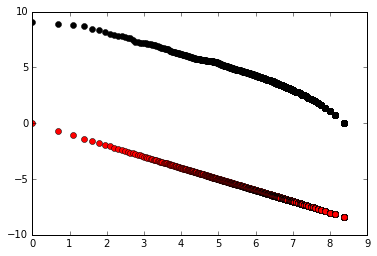

In [11]:
df['x^-1']= [c**-1 for c in df['rank']]

import matplotlib.pyplot as plt

fig = plt.figure()

ax = plt.plot([math.log(c) for c in df['rank'].values], [math.log(c) for c in df['freq']], 'ro',color='black')

ax2 = plt.plot([math.log(c) for c in df['rank'].values], [math.log(c) for c in df['x^-1']], 'ro')

## A3. If we remove stopwords and lemmatize the corpus, what are the 10 most common words? What is their frequency?

In [12]:
from nltk.corpus import stopwords

from nltk.stem import PorterStemmer, WordNetLemmatizer

corpus_words= [word for word in corpus_words if word not in set(string.punctuation)]

filtered_words_sw = [word for word in corpus_words if word not in stopwords.words('english')]

wnl = WordNetLemmatizer()
words_lem = [wnl.lemmatize(word) for word in filtered_words_sw]

fdist_2 = nltk.FreqDist(words_lem)
fdist_2.most_common(10)

[(u'care', 3060),
 (u'home', 2117),
 (u'experience', 1366),
 (u'manager', 1276),
 (u'nurse', 1266),
 (u'work', 1201),
 (u'nursing', 1180),
 (u'support', 1093),
 (u'within', 1040),
 (u'working', 965)]

## PART B 

  ## B1 Create a classification model with all words and the bag-of-words approach. How accurate is the model (show the confusion matrix)? 

In [29]:
#create a function that counts the frequency of each token in a document
def document_features(document):
    document_words = set(document)
    features = {}
    for word in corpus_words:
        features['contains({})'.format(word)] = (word in document_words)
    return features

In [30]:
#find the cutoff salary
cutoff = np.percentile(train[['SalaryNormalized']], 75)
train['category'] = 'high'
train.ix[train.SalaryNormalized < cutoff, 'category'] = 'low'

train['token'] = ""
fullset = train[['FullDescription','token','category']][:1000]

#calculate the document_features in each document
from __future__ import unicode_literals
for i in range(len(fullset)):
    words = re.sub(r'[^\w\s]','',fullset.FullDescription[i])
    token = nltk.word_tokenize(words.lower().decode('utf-8'))
    feature = document_features(token)
    fullset.token[i] = feature

In [31]:
fullset['feature_sets'] = zip(fullset.token, fullset.category)
featuresets = fullset.feature_sets.tolist()
train_set, test_set = featuresets[:500], featuresets[500:]
classifier = nltk.NaiveBayesClassifier.train(train_set)

In [16]:
print 'the accuracy is ', nltk.classify.accuracy(classifier, test_set)

the accuracy is  0.822


In [32]:
#confusion matrix
test_mod = [x[0] for x in test_set]
predict = classifier.classify_many(test_mod)
actual = [x[1] for x in test_set]
cm = nltk.ConfusionMatrix(actual, predict)
print (cm.pretty_format(sort_by_count=True, show_percents=True))

     |             h |
     |      l      i |
     |      o      g |
     |      w      h |
-----+---------------+
 low | <80.6%>  8.6% |
high |   9.2%  <1.6%>|
-----+---------------+
(row = reference; col = test)



## B2 . Speculate before running the following analysis whether lemmatization would help improve the accuracy of classification. Now create a classification model after lemmatization. Did the classification accuracy increase relative to B1? Comment on your speculation versus the actual results you obtained. 

The lemmtization should improve the accuracy since there will be fewer tokens. With each token appearing in a document, the likelihood of the document being positive or negative will increase.

In [33]:
#Lemmatize words according to their pos in the corpus
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

for i in range(len(fullset)):
    words = re.sub(r'[^\w\s]','',fullset.FullDescription[i])
    token = nltk.word_tokenize(words.lower().decode('utf-8'))
    pos_i = nltk.pos_tag(token)
    wordnet_tag ={'NN':'n','JJ':'a','VB':'v','RB':'r'}
    resultList = []
    for t in pos_i:
        try: resultList.append(wnl.lemmatize(t[0],wordnet_tag[t[1][:2]]))
        except: resultList.append(wnl.lemmatize(t[0]))
    feature = document_features(resultList)
    fullset.token[i] = feature

In [34]:
#Run classification model
fullset['feature_sets'] = zip(fullset.token, fullset.category)
featuresets = fullset.feature_sets.tolist()
train_set, test_set = featuresets[:500], featuresets[500:]
classifier = nltk.NaiveBayesClassifier.train(train_set)

In [19]:
print 'the accuracy: ', nltk.classify.accuracy(classifier, test_set)

the accuracy:  0.82


In [35]:
#confusion matrix
test_mod = [x[0] for x in test_set]
predict = classifier.classify_many(test_mod)
actual = [x[1] for x in test_set]
cm = nltk.ConfusionMatrix(actual, predict)
print (cm.pretty_format(sort_by_count=True, show_percents=True))

     |             h |
     |      l      i |
     |      o      g |
     |      w      h |
-----+---------------+
 low | <80.8%>  8.4% |
high |   9.6%  <1.2%>|
-----+---------------+
(row = reference; col = test)



After lemmatization, the accuracy actually went down from 0.822 to 0.82. Hence lemmatization has minimal impact on the classification performance.

## B3. Now speculate whether stopwords removal from the original data would help increase the accuracy of the model. Take out the stopwords (but do not lemmatize), build a classification model and check the accuracy, and compare with that in B1 & B2.

Stop words were did not have strong predictive power in our classification model. It should not change the accuracy significantly.

In [20]:
from nltk.corpus import stopwords
import re

from __future__ import unicode_literals
for i in range(len(fullset)):
    words = re.sub(r'[^\w\s]','',fullset.FullDescription[i])
    words = re.sub("[^a-zA-Z]", " ", words)
    words = words.lower().split()
    stops = set(stopwords.words("english")) 
    meaningful_words = [w for w in words if not w in stops] 
    clean_data = " ".join(meaningful_words)
    token = nltk.word_tokenize(clean_data.lower().decode('utf-8'))
    feature = document_features(token)
    fullset.token[i] = feature

In [21]:
fullset['feature_sets'] = zip(fullset.token, fullset.category)
featuresets = fullset.feature_sets.tolist()
train_set, test_set = featuresets[:500], featuresets[500:]
classifier = nltk.NaiveBayesClassifier.train(train_set)

print(nltk.classify.accuracy(classifier, test_set))

0.82


In [22]:
print classifier.show_most_informative_features(10)

# Printing confusion matrix
test_set_mod = [x[0] for x in test_set]

predicted_categories_NaiveBayes = classifier.classify_many(test_set_mod)
actual_categories = [x[1] for x in test_set]

cm = nltk.ConfusionMatrix(actual_categories, predicted_categories_NaiveBayes)
print(cm.pretty_format(sort_by_count=True, show_percents=True))

Most Informative Features
      contains(regional) = True             high : low    =     20.9 : 1.0
  contains(relationship) = True             high : low    =     20.9 : 1.0
 contains(profitability) = True             high : low    =     20.9 : 1.0
 contains(presentations) = True             high : low    =     18.1 : 1.0
    contains(governance) = True             high : low    =     18.1 : 1.0
        contains(doctor) = True             high : low    =     16.3 : 1.0
contains(decommissioning) = True             high : low    =     16.3 : 1.0
          contains(aero) = True             high : low    =     16.3 : 1.0
         contains(units) = True             high : low    =     16.3 : 1.0
     contains(inservice) = True             high : low    =     16.3 : 1.0
None
     |             h |
     |      l      i |
     |      o      g |
     |      w      h |
-----+---------------+
 low | <80.6%>  8.6% |
high |   9.4%  <1.4%>|
-----+---------------+
(row = reference; col = test)



## B4 .  Use the job descriptions without lemmatiztion and stopword removal. Add parts-of-speech bigrams to the bag-of-words, and run a new classification model. Does the accuracy increase over the results in B1?

(1) Add parts-of-speech bigrams to the bag-of-words

In [23]:
pos_bigram = list(nltk.bigrams(pos))
pattern = [('JJ', 'NN'),('JJ','NNS'),('NN','NNS')]
import copy
corpus_words_bi = copy.deepcopy(corpus_words)

for i in range(len(pos_bigram)):
    (a,b),(c,d) = pos_bigram[i]
    if (b,d) in pattern:
        corpus_words_bi.append(' '.join(corpus_words[i:i+len(pattern)]))

(2) Define the function to create new features

In [24]:
def document_features_bigram(document):
    document_words = set(document)
    features = {}
    for wd in corpus_words_bi:
        features['contains({})'.format(wd)] = (wd in document_words)
    return features

(3) Find out the unigrams and bigrams in each job description that match the part-of-speech patterns we defined

In [25]:
for i in range(len(fullset)):
    words = re.sub(r'[^\w\s]','',fullset.FullDescription[i])
    tokens = nltk.word_tokenize(words.lower().decode('utf-8'))
    tokens = [w for w in tokens if w.isalpha()==True]
    tags = nltk.pos_tag(tokens)
    bigram = list(nltk.bigrams(tags))
    for n in range(len(bigram)):
        (a,b),(c,d) = bigram[n]
        if (b,d) in pattern:
            tokens.append(' '.join(tokens[n:n+len(pattern)]))
    feature = document_features_bigram(tokens)
    fullset.token[i] = feature

(4) Run classification model

In [27]:
fullset['feature_sets'] = zip(fullset.token, fullset.category)
featuresets = fullset.feature_sets.tolist()
train_set, test_set = featuresets[:500], featuresets[500:]
classifier = nltk.NaiveBayesClassifier.train(train_set)
nltk.classify.accuracy(classifier, test_set)

0.804

In [28]:
#confusion matrix
test_mod = [x[0] for x in test_set]
predict = classifier.classify_many(test_mod)
actual = [x[1] for x in test_set]
cm = nltk.ConfusionMatrix(actual, predict)
print (cm.pretty_format(sort_by_count=True, show_percents=True))

     |             h |
     |      l      i |
     |      o      g |
     |      w      h |
-----+---------------+
 low | <78.4%> 10.8% |
high |   8.8%  <2.0%>|
-----+---------------+
(row = reference; col = test)

